# Spotify Song Analysis

The goal of this notebook is to analyze a dataset of songs from Spotify to uncover patterns by running cluster analysis. As a result songs with similar characteristics will be grouped in playlists.

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

In [118]:
# load data from gustavos github

username = "datagus"
repository = "ASDA2025"
directory = "refs/heads/main/datasets/homework_week11/6.3.3_spotify_5000_songs.csv"
github_url = f"https://raw.githubusercontent.com/{username}/{repository}/{directory}"
df = pd.read_csv(github_url)

In [119]:
#clean / strip data
df.columns = df.columns.str.strip()

In [120]:
df.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'id', 'html'],
      dtype='object')

Hot encode categorical variables first

In [121]:

# df_encoded = pd.get_dummies(
#     df,
#     columns=["key", "mode", "time_signature"],
#     drop_first=False)
#
# df_encoded = df_encoded.copy()
#
# bool_cols = df_encoded.select_dtypes(include="bool").columns
# df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [122]:
#identify numerical columns
# df_encoded.select_dtypes(include="number").columns.tolist()

In [123]:
clustering_features = df.select_dtypes(include="number").columns.tolist()

# enable if using hot encoded data
#clustering_features = df_encoded.select_dtypes(include="number").columns.tolist()


# Create a dataframe with only these features
X = df[clustering_features].copy()

# enable if using hot encoded data
# X = df_encoded[clustering_features].copy()


X = X.dropna(axis=0)

## Normalizing the data
This is done to ensure that all features contribute equally to the distance calculations during clustering. This is a preparation for k-means clustering algorithm.

In [124]:
mins = X.min()
maxs = X.max()

# Min-Max normalization
# Formula: (value - min) / (max - min)
X_normalized = (X - mins) / (maxs - mins)* 9 + 1

In [125]:
X_normalized

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7.124095,3.33100,10.000000,7.875077,1.0,1.691176,7.271084,1.000536,9.890578,3.795939,5.642198,1.531605,8.2
1,7.905895,4.59100,2.636364,7.947703,10.0,1.339216,2.960843,1.000017,1.975684,7.331980,6.258895,1.378523,8.2
2,8.920372,7.57000,2.636364,8.182159,10.0,4.401961,5.093373,1.000579,2.130699,9.269036,4.940754,1.284313,8.2
3,7.561531,1.45180,4.272727,7.145300,10.0,1.461765,8.942771,1.000370,4.519757,5.787817,5.491883,1.365105,8.2
4,7.058945,2.07100,5.909091,6.897053,10.0,1.372549,9.277108,1.003134,1.948328,4.673096,6.086541,1.573160,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,2.880041,1.62460,3.454545,6.371361,10.0,1.463725,9.286145,7.532995,1.758663,1.598477,4.697154,3.289214,8.2
5231,2.749741,1.90900,5.909091,6.593932,10.0,1.433333,8.725904,4.892386,1.632827,1.324365,4.496453,2.956148,8.2
5232,1.554705,1.00837,8.363636,3.500228,10.0,1.425490,9.593373,9.853807,1.703951,1.314315,4.010220,1.488721,6.4
5233,2.237849,1.18720,4.272727,5.483274,10.0,1.410784,8.978916,5.614213,2.012158,1.540000,3.822473,1.669814,8.2


In [126]:
X_normalized.describe()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000
mean,5.742013,6.882082,5.299088,8.433033,6.816046,1.815473,3.620872,3.351299,2.690154,5.053165,5.993190,1.511855,8.025330
std,2.029337,2.595015,2.922185,0.923570,4.303668,0.697972,3.216729,3.386981,1.362399,2.537590,1.201534,0.322677,0.756584
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.875905,5.311000,2.636364,8.139757,1.000000,1.382353,1.022139,1.000009,1.843465,2.790863,5.044890,1.374060,8.200000
50%,6.016546,7.642000,5.090909,8.726484,10.000000,1.547059,1.862048,1.017178,2.139818,4.810152,6.012477,1.456556,8.200000
75%,7.403309,9.037000,7.545455,9.030778,10.000000,1.967157,6.109940,6.875127,3.161094,7.185787,6.636576,1.568497,8.200000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


## Initalize K-Means Clustering and Assign each point to a Cluster

In [127]:
# Number of clusters
k = 7

# Randomly sample k rows from the dataframe as initial centroids
centroids = X_normalized.sample (k, random_state=42)
centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
3075,6.230610,8.0470,10.000000,9.109566,1.0,1.419608,2.219880,1.000132,3.571429,4.572589,6.554185,1.354542,8.2
1268,7.375388,6.1390,2.636364,8.097796,10.0,1.293137,4.027108,1.000022,2.951368,8.940102,6.120020,1.360219,8.2
422,5.681489,5.0230,7.545455,7.859085,10.0,3.647059,6.981928,1.000113,4.109422,7.222335,5.679546,1.262330,8.2
2543,5.579111,2.8450,8.363636,8.557758,1.0,1.565686,9.882530,9.159391,2.112462,1.995939,6.396677,1.659698,8.2
2842,5.709411,7.5340,5.090909,8.928075,1.0,1.358824,1.027831,1.000736,3.425532,3.430457,6.385280,1.408382,8.2
5157,1.623578,1.4527,1.000000,5.814564,10.0,1.414706,9.683735,8.830457,1.836170,1.320711,4.056147,4.212285,8.2
4460,3.540848,9.7390,7.545455,8.785172,1.0,2.382353,1.007120,5.038579,4.683891,2.315736,5.257283,1.441901,8.2


In [128]:
# Initialize a DataFrame to store distances from each point to each centroid
distances = pd.DataFrame()


# Calculate distance from each point to each centroid
for i in range(k):
    # Get the i-th centroid as a pandas Series
    centroid_i = centroids.iloc[i]

     # Subtract centroid from all rows in X_normalized
    differences = X_normalized.subtract(centroid_i, axis=1)

    # Square each difference
    squared_differences = differences ** 2

    # Sum across all features (columns) for each point (row)
    sum_of_squared_differences = squared_differences.sum(axis=1)

    # Take the square root to get Euclidean distance. Use np.sqrt
    euclidean_distance = np.sqrt(sum_of_squared_differences)

    # Store this distance in the distances DataFrame
    distances[f'centroid_{i}'] = euclidean_distance

# Assign each point to its nearest centroid
# Find which centroid has the minimum distance for each row
cluster_assignmentes = distances.idxmin(axis=1)

# Extract just the cluster number (remove 'centroid_' prefix)
cluster_labels = cluster_assignmentes.str.replace('centroid_', '').astype(int)

# Create a result DataFrame with cluster assignments
X_with_clusters = X_normalized.copy()
X_with_clusters['cluster'] = cluster_labels

# Display first 10 rows
X_with_clusters.sample(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
325,7.152017,6.913,6.727273,8.516824,10.0,1.801961,5.753012,1.263147,4.200608,9.570558,7.281747,1.188547,8.2,2
3929,2.786970,9.613,5.909091,7.558312,10.0,1.542157,1.000459,8.510660,4.282675,1.968528,7.580948,1.552034,8.2,6
524,3.764219,4.285,5.090909,8.578299,10.0,1.318627,9.430723,1.250355,1.701216,3.384772,8.430478,1.673144,8.2,2
5218,1.867425,1.675,1.818182,6.204688,10.0,1.347059,9.385542,6.674112,1.585410,1.324365,4.603238,3.306344,8.2,5
684,9.087901,5.365,5.909091,8.982214,10.0,1.534314,3.222892,1.000000,1.697568,5.815228,5.459330,1.408582,8.2,1
3988,3.215098,9.397,2.636364,9.064377,10.0,1.883333,1.000083,4.727919,4.601824,4.554315,6.163087,1.412241,8.2,1
3572,3.382627,9.181,1.000000,8.860145,1.0,1.634314,1.000000,9.698477,2.094225,2.589848,5.630674,1.480853,8.2,6
2223,8.948294,7.390,4.272727,8.875844,1.0,1.777451,1.102108,1.000797,2.513678,8.474112,5.495752,1.433431,8.2,4
2369,5.886246,9.226,3.454545,9.189381,10.0,1.691176,1.000239,1.011604,1.522492,5.212183,5.674541,1.386707,8.2,1
4796,6.630817,5.401,2.636364,8.974438,1.0,1.275490,2.012048,1.000000,2.139818,2.078173,4.280401,1.457664,8.2,4


In [129]:
distances

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,9.568137,15.125320,11.879140,11.978896,11.245485,18.653049,12.092673
1,12.732929,2.719733,7.459953,16.302232,11.070205,14.563663,14.355331
2,13.690777,4.173929,7.346309,17.324490,12.710221,16.213205,15.204622
3,14.547569,7.910305,6.196827,13.933556,13.981509,12.121338,16.477739
4,13.847282,8.696550,6.007274,12.915025,13.760579,11.788516,16.058035
...,...,...,...,...,...,...,...
5230,17.197372,13.254124,11.546783,11.291233,16.016987,3.336625,16.070101
5231,15.246054,12.427052,9.531556,11.193666,14.681328,6.665009,14.969275
5232,18.523994,17.057250,13.774195,11.676003,18.684132,8.456620,17.386049
5233,16.616697,12.933338,10.654025,11.889226,15.575111,5.357905,15.878278


## Update Centroids and check for convergence

In [130]:
# Get the feature columns (all columns except 'cluster')
feature_columns = X_with_clusters.columns[:-1]

# Initialize a DataFrame to store the new centroids
new_centroids = pd.DataFrame()

# Calculate the mean of each cluster's points for each feature
for i in range(k):
    # Get all points assigned to cluster i
    cluster_i_points = X_with_clusters.loc[X_with_clusters['cluster'] == i]

    # Calculate the mean of these points across all features
    cluster_i_mean = cluster_i_points[feature_columns].mean()

    # Add this as a new row to new_centroids
    new_centroids = pd.concat([new_centroids, cluster_i_mean.to_frame().T], ignore_index=True)

# Display the new centroids
new_centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7.110907,7.505593,8.772727,8.842456,1.088933,1.903350,2.764451,1.289219,2.775944,6.330844,6.123197,1.476935,8.125296
1,6.463734,7.681457,3.468808,8.760722,9.984311,1.800208,2.408577,2.047035,2.622925,6.197946,6.128923,1.463396,8.121557
2,5.885253,6.029449,7.601455,8.406724,9.979118,1.756378,5.114733,1.575633,2.894996,5.295602,5.973407,1.477854,8.028770
3,4.397087,2.421124,5.919481,6.820149,1.457143,1.457488,9.232731,7.542064,2.251400,2.855794,5.456965,1.649084,7.777143
4,6.712561,7.457177,3.869677,8.832238,1.144966,1.921715,2.619842,1.300264,2.749279,5.693339,6.090806,1.472716,8.117852
5,3.697110,2.133793,4.277273,6.521592,10.000000,1.444292,9.354825,8.376396,2.204030,2.230695,5.387505,1.772448,7.540000
6,3.508606,9.264851,6.187453,8.640095,6.107438,2.090935,1.066888,7.783213,2.917260,2.857129,6.037136,1.542838,7.976860


In [131]:
# Calculate the distance each centroid moved
centroid_movements = pd.DataFrame()

for i in range(k):
    # Get old and new centroid positions
    old_centroid = centroids.iloc[i]
    new_centroid = new_centroids.iloc[i]

    # Calculate Euclidean distance between old and new position
    differences_2 = new_centroid - old_centroid
    squared_differences_2 = differences_2 ** 2
    sum_of_squared_differences_2 = squared_differences_2.sum(axis=0)
    movement = np.sqrt(sum_of_squared_differences_2)

    centroid_movements[f'centroid_{i}'] = [movement]

centroid_movements

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,2.682946,3.995014,3.754931,3.955924,3.339227,5.044142,6.315121


## Create functions and run the K-Means Algorithm

In [132]:
def getting_centroids(X_normalized, centroids, k):

    distances = pd.DataFrame()

    for i in range(k):
        centroid_i = centroids.iloc[i]
        differences = X_normalized.subtract(centroid_i, axis=1)
        squared_differences = differences ** 2
        sum_of_squared_differences = squared_differences.sum(axis=1)
        euclidean_distance = np.sqrt(sum_of_squared_differences)
        distances[f'centroid_{i}'] = euclidean_distance

    cluster_assignmentes = distances.idxmin(axis=1)
    cluster_labels = cluster_assignmentes.str.replace('centroid_', '').astype(int)

    X_with_clusters = X_normalized.copy()
    X_with_clusters['cluster'] = cluster_labels

    return X_with_clusters

In [133]:
def getting_new_centroids(X_with_clusters, k):
    # Get the feature columns (all columns except 'cluster')
    feature_columns = X_with_clusters.columns[:-1]

    # Initialize a DataFrame to store the new centroids
    new_centroids = pd.DataFrame()

    # Calculate the mean of each cluster's points for each feature
    for i in range(k):
        # Get all points assigned to cluster i
        cluster_i_points = X_with_clusters.loc[X_with_clusters['cluster'] == i]

        # Calculate the mean of these points across all features
        cluster_i_mean = cluster_i_points[feature_columns].mean()

        # Add this as a new row to new_centroids
        new_centroids = pd.concat([new_centroids, cluster_i_mean.to_frame().T], ignore_index=True)

    return new_centroids
new_centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7.110907,7.505593,8.772727,8.842456,1.088933,1.903350,2.764451,1.289219,2.775944,6.330844,6.123197,1.476935,8.125296
1,6.463734,7.681457,3.468808,8.760722,9.984311,1.800208,2.408577,2.047035,2.622925,6.197946,6.128923,1.463396,8.121557
2,5.885253,6.029449,7.601455,8.406724,9.979118,1.756378,5.114733,1.575633,2.894996,5.295602,5.973407,1.477854,8.028770
3,4.397087,2.421124,5.919481,6.820149,1.457143,1.457488,9.232731,7.542064,2.251400,2.855794,5.456965,1.649084,7.777143
4,6.712561,7.457177,3.869677,8.832238,1.144966,1.921715,2.619842,1.300264,2.749279,5.693339,6.090806,1.472716,8.117852
5,3.697110,2.133793,4.277273,6.521592,10.000000,1.444292,9.354825,8.376396,2.204030,2.230695,5.387505,1.772448,7.540000
6,3.508606,9.264851,6.187453,8.640095,6.107438,2.090935,1.066888,7.783213,2.917260,2.857129,6.037136,1.542838,7.976860


In [134]:
def centroids_movement (k, centroids, new_centroids):
    # Calculate the distance each centroid moved
    centroid_movements = pd.DataFrame()

    for i in range(k):
        # Get old and new centroid positions
        old_centroid = centroids.iloc[i]
        new_centroid = new_centroids.iloc[i]

        # Calculate Euclidean distance between old and new position
        differences_2 = new_centroid - old_centroid
        squared_differences_2 = differences_2 ** 2
        sum_of_squared_differences_2 = squared_differences_2.sum()
        movement = np.sqrt(sum_of_squared_differences_2)

        centroid_movements[f'centroid_{i}'] = [movement]

    return centroid_movements
centroid_movements

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,2.682946,3.995014,3.754931,3.955924,3.339227,5.044142,6.315121


## Running PCA to explore variance explained by components

In [135]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_normalized)

# Create a DataFrame with PCA results
X_pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)

# Display variance explained
variance_explained = pca.explained_variance_ratio_
print(f"""
**PCA Results:**
- PC1 explains {variance_explained[0]:.2%} of variance
- PC2 explains {variance_explained[1]:.2%} of variance
- Total variance explained: {variance_explained.sum():.2%}
""")


**PCA Results:**
- PC1 explains 27.95% of variance
- PC2 explains 26.17% of variance
- Total variance explained: 54.11%



In [136]:
# Run k-means and store cluster assignments at each iteration
centroides = centroids.copy()
iterations = 100
threshold = 0.001
converged = False

# Store cluster assignments and centroids for each iteration
iteration_data = []

for i in range(iterations):
    # Assign points to nearest centroids
    X_clustered = getting_centroids(X_normalized, centroides, k)

    # Store the cluster assignments for this iteration
    cluster_assignments = X_clustered['cluster']

    # Transform centroids to PCA space
    centroids_pca = pca.transform(centroides)

    # Store iteration data
    iteration_data.append({
        'iteration': i + 1,
        'clusters': cluster_assignments.values,
        'centroids_pc1': centroids_pca[:, 0],
        'centroids_pc2': centroids_pca[:, 1]
    })

    # Calculate new centroids
    new_centroides = getting_new_centroids(X_clustered, k)

    # Calculate how much centroids moved
    movement_df = centroids_movement(k, centroides, new_centroides)
    max_movement = movement_df.max().max()
    # Check for convergence
    if max_movement < threshold:
        converged = True
        print(f"Converged at iteration {i + 1}")
        break

    # Update centroids for next iteration
    centroides = new_centroides

print(f"Total iterations: {len(iteration_data)}")

Converged at iteration 31
Total iterations: 31


In [137]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [138]:
# Get data for selected iteration
selected_iteration = len(iteration_data) - 1
iteration_info = iteration_data[selected_iteration]

# Create DataFrame for plotting
plot_df = X_pca_df.copy()
plot_df['cluster'] = iteration_info['clusters']
plot_df['cluster'] = plot_df['cluster'].astype(str)

# Create DataFrame for centroids
centroids_df = pd.DataFrame({
    'PC1': iteration_info['centroids_pc1'],
    'PC2': iteration_info['centroids_pc2'],
    'cluster': [str(i) for i in range(k)]
})

# Create scatter plot of data points
points = alt.Chart(plot_df).mark_circle(
    size=30,
    opacity=0.6
).encode(
    x=alt.X('PC1:Q', title=f'PC1 ({variance_explained[0]:.1%} variance)'),
    y=alt.Y('PC2:Q', title=f'PC2 ({variance_explained[1]:.1%} variance)'),
    color=alt.Color('cluster:N', title='Cluster',
                    scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('PC1:Q', format='.2f'),
        alt.Tooltip('PC2:Q', format='.2f'),
        'cluster:N'
    ]
)

# Create scatter plot of centroids
centroids_plot = alt.Chart(centroids_df).mark_point(
    shape='cross',
    size=300,
    filled=True,
    strokeWidth=3
).encode(
    x='PC1:Q',
    y='PC2:Q',
    color=alt.Color('cluster:N',
                    scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('PC1:Q', format='.2f'),
        alt.Tooltip('PC2:Q', format='.2f'),
        'cluster:N'
    ]
)

# Combine plots
chart = alt.layer(points, centroids_plot).properties(
    title='K-Means Clustering (PCA space)',
    width=600,
    height=500
)

chart

alt.LayerChart(...)

## K Means with Sklearn

Until here Gustavo led the way (thank you :) ) Now we'll use sklearn to do K Means clustering and group songs into playlists.

In [139]:
from sklearn.cluster import KMeans

# Create a KMeans object with the same parameters
kmeans = KMeans(
    n_clusters=k,  # number of clusters (same k=5 as before)
    random_state=42,  # for reproducibility
    max_iter=1000,  # maximum number of iterations
    n_init=10  # number of times to run with different initializations
)

# Fit the model to the normalized data
kmeans.fit(X_normalized)

# Get the cluster assignments for each point
sklearn_clusters = kmeans.labels_

# Get the final centroids
sklearn_centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X_normalized.columns
)

# Add cluster assignments to the data
X_sklearn_clusters = X_normalized.copy()
X_sklearn_clusters['cluster'] = sklearn_clusters

X_sklearn_clusters.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,7.124095,3.3310,10.000000,7.875077,1.0,1.691176,7.271084,1.000536,9.890578,3.795939,5.642198,1.531605,8.2,4
1,7.905895,4.5910,2.636364,7.947703,10.0,1.339216,2.960843,1.000017,1.975684,7.331980,6.258895,1.378523,8.2,5
2,8.920372,7.5700,2.636364,8.182159,10.0,4.401961,5.093373,1.000579,2.130699,9.269036,4.940754,1.284313,8.2,5
3,7.561531,1.4518,4.272727,7.145300,10.0,1.461765,8.942771,1.000370,4.519757,5.787817,5.491883,1.365105,8.2,3
4,7.058945,2.0710,5.909091,6.897053,10.0,1.372549,9.277108,1.003134,1.948328,4.673096,6.086541,1.573160,8.2,3
5,5.337125,2.3140,3.454545,7.235532,10.0,1.636275,9.412651,2.407107,1.975684,4.864975,7.009463,1.515366,8.2,3
6,7.282316,2.8630,10.000000,7.775456,1.0,1.534314,9.701807,4.782741,2.021277,7.249746,4.933731,1.267469,8.2,0
7,5.690796,7.5970,6.727273,8.230283,10.0,4.813725,7.289157,1.000513,7.136778,9.095431,5.061335,1.658996,8.2,1
8,7.459152,5.9140,9.181818,8.122885,10.0,1.392157,4.596386,1.694416,2.395137,6.856853,8.151213,1.407452,8.2,1
9,7.273009,8.7760,1.818182,8.633612,10.0,1.374510,6.792169,4.271066,2.267477,5.897462,5.205594,1.352986,8.2,5


## Add cluster assignments back to original dataframe

I think its ok to add the cluster assignments back to the original dataframe since we did not drop or shuffle any rows when normalizing.

In [140]:
df_kmean = df.join(X_sklearn_clusters["cluster"])

In [141]:
df.head(10)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
5,Desafinado ...,Stan Getz,0.466,0.1460,3,-17.500,1,0.0649,0.931,0.154000,0.107,0.423,142.885,249387,4,5pstSsK0G4q86gdyy1Spqh,https://open.spotify.com/track/5pstSsK0G4q86gd...
6,Madalena ...,Maria Gasolina,0.675,0.2070,11,-13.820,0,0.0545,0.963,0.414000,0.112,0.684,93.531,145187,4,33u3dO0JWjerYpFN61J3ug,https://open.spotify.com/track/33u3dO0JWjerYpF...
7,O Meu Amor É Glòria ...,Sílvia Pérez Cruz,0.504,0.7330,7,-10.720,1,0.3890,0.696,0.000056,0.673,0.886,96.565,309760,4,0ylJQpV3K4XnhWhLDMFmH7,https://open.spotify.com/track/0ylJQpV3K4XnhWh...
8,Brigas Nunca Mais ...,Paula Morelenbaum,0.694,0.5460,10,-11.452,1,0.0400,0.398,0.076000,0.153,0.641,170.032,204027,4,1wL2dk42Cxu4zCJs4SvFsZ,https://open.spotify.com/track/1wL2dk42Cxu4zCJ...
9,Previsao ...,Bossacucanova,0.674,0.8640,1,-7.971,1,0.0382,0.641,0.358000,0.139,0.536,99.995,181133,4,5iKuMCDh634YGrg2HrhtHp,https://open.spotify.com/track/5iKuMCDh634YGrg...


In [142]:
cols = df_kmean.columns.tolist()
cols.insert(0, cols.pop(cols.index("cluster")))
df_kmean= df_kmean[cols]

Show 5 random songs from each cluster to verify that they make sense together.

In [143]:
df_kmean.groupby("cluster", group_keys=False).sample(n=5, random_state=99)

,cluster,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
5224,0,Symphony No. 6 ...,Allan Pettersson,0.0864,0.0665,10,-26.515,0,0.0452,0.828000,0.797000,0.1350,0.0387,77.880,3590693,3,1HB8dwgqku7790ACIp6LAN,https://open.spotify.com/track/1HB8dwgqku7790A...
506,0,Tú Que Vienes a Rondarme ...,Maria Arnal i Marcel Bagés,0.5770,0.3610,9,-11.442,0,0.0327,0.976000,0.004330,0.1070,0.2150,104.022,215068,4,2bC2DSTXoDaCjRW6AIdzUu,https://open.spotify.com/track/2bC2DSTXoDaCjRW...
4519,0,Moments In Love ...,Kara-Lis Coverdale,0.3970,0.0536,0,-28.425,0,0.0297,0.906000,0.924000,0.0903,0.1650,72.158,563428,1,2CxBaNFCjYVi0Iv2PpeZDG,https://open.spotify.com/track/2CxBaNFCjYVi0Iv...
4575,0,Yulquen ...,Autechre,0.4170,0.1110,9,-31.491,0,0.0409,0.826000,0.940000,0.1110,0.5550,148.094,397000,5,3PGYnbU4HJDUw01PrME2pz,https://open.spotify.com/track/3PGYnbU4HJDUw01...
2087,0,"Partita No. 6 in E Minor, BWV 830: IV. Air ...",Johann Sebastian Bach,0.3800,0.0842,4,-30.289,0,0.0402,0.994000,0.841000,0.1290,0.5320,144.768,109720,4,4KuGb0cwL8KKSySLhS5F3H,https://open.spotify.com/track/4KuGb0cwL8KKSyS...
2790,1,Joyenergizer - Original Mix ...,Sander van Doorn,0.7910,0.9810,5,-5.089,1,0.2050,0.003060,0.041500,0.2370,0.0588,127.998,314063,4,2KlsoPw8FqUKsIcDUOP6fR,https://open.spotify.com/track/2KlsoPw8FqUKsIc...
4235,1,Pedigree Butchery ...,Carcass,0.2070,0.7920,11,-13.238,1,0.0926,0.000014,0.348000,0.1140,0.2780,77.158,316333,4,5f58ajCZ69vn7ZCVwQR0Pz,https://open.spotify.com/track/5f58ajCZ69vn7ZC...
2734,1,Antidote - Radio Edit ...,Swedish House Mafia,0.6480,0.8590,7,-4.974,1,0.1110,0.006450,0.028200,0.1350,0.6330,128.030,177250,4,38JE3O2HocFNvtljgtlNKv,https://open.spotify.com/track/38JE3O2HocFNvtl...
953,1,For Once In My Life ...,Stevie Wonder,0.5240,0.5190,6,-11.903,1,0.0430,0.195000,0.000000,0.5230,0.8470,110.121,169800,4,4kP69y3GKHi9tXckfgp4bK,https://open.spotify.com/track/4kP69y3GKHi9tXc...
3333,1,Te Iré a Buscar ...,Farruko,0.7350,0.7420,6,-5.865,1,0.0474,0.094800,0.000000,0.1770,0.9640,174.025,183197,4,4UPeS038Mxup1H4bl0PsS8,https://open.spotify.com/track/4UPeS038Mxup1H4...


In [144]:
df_kmean["cluster"].value_counts().sort_index()

cluster
0     333
1    1124
2     663
3     603
4    1182
5     993
6     337
Name: count, dtype: int64

In [145]:
cluster_sizes = df_kmean['cluster'].value_counts().reset_index()
cluster_sizes.columns = ['cluster','count']

alt.Chart(cluster_sizes).mark_bar().encode(
    x='cluster:N',
    y='count:Q',
    tooltip=['cluster','count']
).properties(title='Number of Songs per Cluster',
    width=500,
    height=400)


alt.Chart(...)

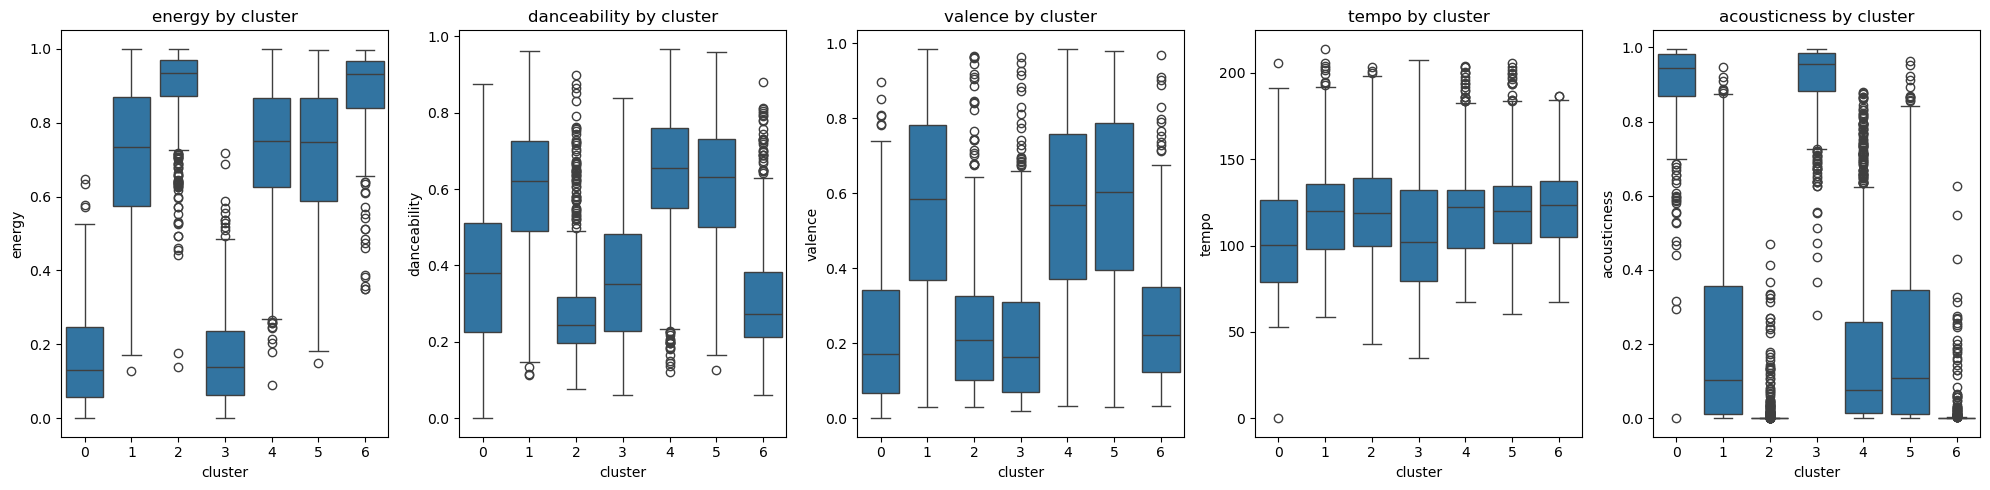

In [177]:
features = ["energy", "danceability", "valence", "tempo", "acousticness"]

# Create one row with one plot per feature
fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 5), sharey=False)

for i, f in enumerate(features):
    sns.boxplot(
        x="cluster",
        y=f,
        data=df_kmean,
        ax=axes[i]
    )
    
    axes[i].set_title(f"{f} by cluster")
    axes[i].set_xlabel("cluster")
    axes[i].set_ylabel(f)

plt.tight_layout()
plt.show()


## DBSCAN performed 

In [147]:
X_dbscan = X_pca_df[['PC1', 'PC2']]
dbscan = DBSCAN(eps=0.5, min_samples=10)

In [148]:
dbscan_labels = dbscan.fit_predict(X_dbscan)
plot_df['dbscan_cluster'] = dbscan_labels.astype(str)

In [149]:
unique_clusters = set(dbscan_labels)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

print("Number of DBSCAN clusters:", n_clusters)
print("Noise points:", list(dbscan_labels).count(-1))


Number of DBSCAN clusters: 4
Noise points: 17


In [150]:
dbscan_plot = alt.Chart(plot_df).mark_circle(
    size=30,
    opacity=0.6
).encode(
    x=alt.X('PC1:Q', title='PC1'),
    y=alt.Y('PC2:Q', title='PC2'),
    color=alt.Color('dbscan_cluster:N',
                    scale=alt.Scale(scheme='category10'),
                    title='DBSCAN Cluster'),
    tooltip=['PC1', 'PC2', 'dbscan_cluster']
).properties(
    title='DBSCAN Clustering (PCA space)',
    width=600,
    height=500
)

dbscan_plot


alt.Chart(...)

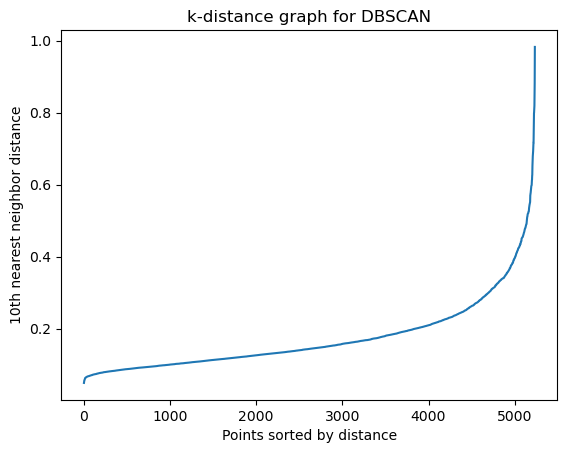

In [151]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

distances = np.sort(distances[:, 9])

plt.figure()
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('10th nearest neighbor distance')
plt.title('k-distance graph for DBSCAN')
plt.show()


## silhouette score

In [152]:
dbscan_labels = dbscan_labels  # your DBSCAN result
X_sil = X_dbscan
mask = dbscan_labels != -1
X_dbscan_sil = X_sil[mask]
dbscan_labels_clean = dbscan_labels[mask]


In [153]:
if len(set(dbscan_labels_clean)) > 1:
    sil_dbscan = silhouette_score(X_dbscan_sil, dbscan_labels_clean)
    print(f"Silhouette Score (DBSCAN): {sil_dbscan:.3f}")
else:
    print("DBSCAN found less than 2 clusters — silhouette score not defined.")


Silhouette Score (DBSCAN): 0.503


In [154]:
spotify_dbscan = df.copy()   # your original dataset
spotify_dbscan['dbscan_cluster'] = dbscan_labels


In [155]:
display(spotify_dbscan['dbscan_cluster'].value_counts())

cluster_sizes = spotify_dbscan['dbscan_cluster'].value_counts().reset_index()
cluster_sizes.columns = ['cluster','count']

alt.Chart(cluster_sizes).mark_bar().encode(
    x='cluster:N',
    y='count:Q',
    tooltip=['cluster','count']
).properties(title='Number of Songs per DBSCAN Playlist',
    width=500,
    height=400)


dbscan_cluster
 1    3382
 0    1603
 3     203
 2      30
-1      17
Name: count, dtype: int64

alt.Chart(...)

In [156]:
for c in sorted(spotify_dbscan['dbscan_cluster'].unique()):
    print(f"\nDBSCAN Cluster {c}")
    display(
        spotify_dbscan[spotify_dbscan['dbscan_cluster'] == c]
        [['name','artist']]
        .sample(5, random_state=42)
    )


DBSCAN Cluster -1


,name,artist
33,O Amor Em Paz ...,Cannonball Adderley
1833,I. Adagio sostenuto ...,Ludwig van Beethoven
2405,"Werther: ""Pourquoi me réveiller, ô souffle du ...",Jules Massenet
5177,Jonchaies ...,Iannis Xenakis
4547,Triennale ...,Brian Eno



DBSCAN Cluster 0


,name,artist
2170,My Name Is ...,Eminem
3640,The Process of Suffocation ...,Pestilence
586,Blanco ...,J Balvin
476,Alaska ...,Maggie Rogers
4258,Feces for Jesus ...,Severe Torture



DBSCAN Cluster 1


,name,artist
571,Super Bass ...,Nicki Minaj
461,The Waiting ...,Angel Olsen
677,Middle ...,DJ Snake
1211,Rebel Rebel - 2016 Remaster ...,David Bowie
2206,Ignition - Remix ...,R. Kelly



DBSCAN Cluster 2


,name,artist
4537,Dungeoneering ...,Tim Hecker
2511,Love Theme From Spartacus - Remastered ...,Yusef Lateef
2614,The Shadow of Your Smile ...,Dexter Gordon
2522,Blue Bossa - Remastered ...,Joe Henderson
2440,"La forza dell’amore e dell’odio: ""Vado a morir...",Francesco Araia



DBSCAN Cluster 3


,name,artist
1871,Lost ...,Annelie
1848,To the Sky (Moderate) ...,Dirk Maassen
2398,"Pagliacci / Act 1: ""Recitar!...Vesti la giubba...",Ruggero Leoncavallo
2040,Grey Light ...,Francesco Tristano
2012,"The Well-Tempered Clavier, Book I: Prelude No....",Johann Sebastian Bach


## Agglomerative Hierarchical Clustering with Scikit-Learn and Scipy

In [157]:
X_hier = X_pca_df[['PC1','PC2']]

In [158]:
agg = AgglomerativeClustering(
    n_clusters=4,        # same as K-Means for fair comparison
    linkage='ward'      # best for numeric continuous data
)
agg_labels = agg.fit_predict(X_hier)


In [159]:
spotify_hier = df.copy()
spotify_hier['hier_cluster'] = agg_labels


In [160]:
spotify_hier['hier_cluster'].value_counts()


hier_cluster
0    2822
3    1162
1     690
2     561
Name: count, dtype: int64

In [161]:
for c in sorted(spotify_hier['hier_cluster'].unique()):
    print(f"\nHierarchical Cluster {c}")
    display(
        spotify_hier[spotify_hier['hier_cluster'] == c]
        [['name','artist']]
        .sample(5, random_state=42)
    )



Hierarchical Cluster 0


,name,artist
1643,I Know You Want Me (Calle Ocho) ...,Pitbull
4649,After School ...,Weeekly
2872,Mantra - Axwell Cut ...,Michael Feiner
2790,Joyenergizer - Original Mix ...,Sander van Doorn
1668,Boom Boom Pow ...,Black Eyed Peas



Hierarchical Cluster 1


,name,artist
2483,Alone Together ...,Peggy Lee
4087,Sentenced for Life ...,Massacra
2367,My Girlfriend's Girlfriend ...,Type O Negative
2581,It Ain't Necessarily So ...,Mary Lou Williams
2547,Solar - Rudy Van Gelder Remaster ...,Miles Davis Quintet



Hierarchical Cluster 2


,name,artist
5168,Turangalila-symphonie: I. Introduction ...,Olivier Messiaen
2438,"Die Zauberflöte, K.620: Overture ...",Wolfgang Amadeus Mozart
1963,Moments ...,Alexis Ffrench
1050,What A Wonderful World ...,Louis Armstrong
2427,"Rigoletto / Act 1: ""Gualtier Maldè...Caro nome...",Giuseppe Verdi



Hierarchical Cluster 3


,name,artist
1442,Over My Shoulder ...,Mike & The Mechanics
628,Sucker ...,Jonas Brothers
4864,Das kleine Küken piept - Radio Edit ...,Pulcino Pio
2820,Strong ...,R3HAB
3193,Agárrala - Remix ...,Trebol Clan


In [162]:
plot_df['hier_cluster'] = agg_labels.astype(str)

alt.Chart(plot_df).mark_circle(size=35, opacity=0.6).encode(
    x='PC1:Q',
    y='PC2:Q',
    color=alt.Color('hier_cluster:N', title='Hierarchical Cluster'),
    tooltip=['PC1','PC2','hier_cluster']
).properties(
    title='Hierarchical Clustering (PCA Space)',
    width=650,
    height=500
)


alt.Chart(...)

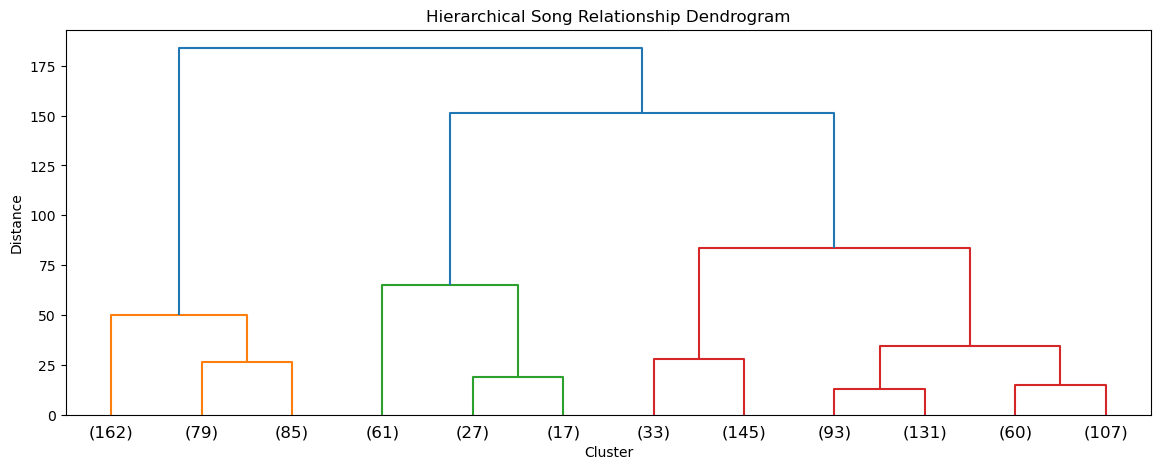

In [163]:
sample = X_hier.sample(1000, random_state=42)   # keep it readable

Z = linkage(sample, method='ward')

plt.figure(figsize=(14,5))
dendrogram(Z, truncate_mode='lastp', p=12)
plt.title("Hierarchical Song Relationship Dendrogram")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.show()


## gustavo's code for Hierarchical Clustering

In [164]:
from scipy.cluster.hierarchy import linkage
import pandas as pd

# Use PCA-reduced data (much faster & cleaner)
X_link = X_pca_df[['PC1','PC2']]

linkage_matrix = linkage(
    X_link,
    method='ward',
    metric='euclidean'
)

linkage_matrix_df = pd.DataFrame(
    linkage_matrix,
    columns=['cluster_1', 'cluster_2', 'distance', 'n_observations']
)

linkage_matrix_df.head(10)


,cluster_1,cluster_2,distance,n_observations
0,0.0,174.0,0.0,2.0
1,10.0,2494.0,0.0,2.0
2,1107.0,1246.0,0.0,2.0
3,691.0,1695.0,0.0,2.0
4,574.0,1806.0,0.0,2.0
5,669.0,2648.0,0.0,2.0
6,85.0,144.0,0.0,2.0
7,68.0,107.0,0.0,2.0
8,866.0,2446.0,0.0,2.0
9,668.0,2666.0,0.0,2.0


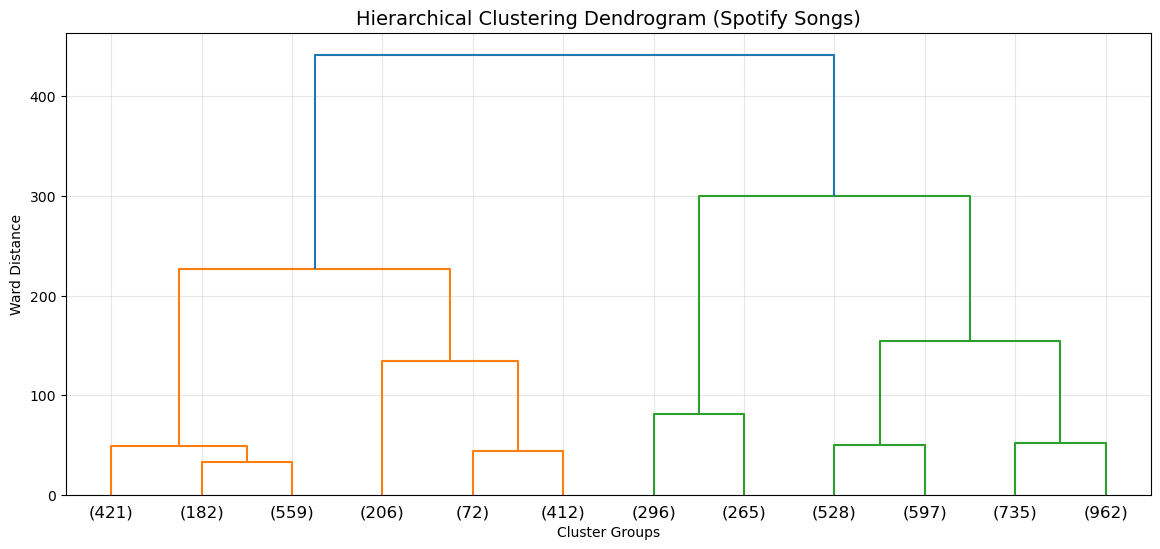

In [165]:
# Build linkage on PCA space (fast & clean)
X_link = X_pca_df[['PC1','PC2']]
linkage_matrix = linkage(X_link, method='ward', metric='euclidean')

# Create dendrogram
plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',   # show only last clusters
    p=12,                    # number of final clusters shown
    no_labels=False
)

plt.title('Hierarchical Clustering Dendrogram (Spotify Songs)', fontsize=14)
plt.xlabel('Cluster Groups')
plt.ylabel('Ward Distance')
plt.grid(True, alpha=0.3)
plt.show()


## created a playlist of songs 

In [166]:
spotify_dbscan[
    spotify_dbscan['dbscan_cluster'] == 1
][['name', 'artist']].head(10)


,name,artist
1,Saudade De Bahia ...,Antônio Carlos Jobim
2,"Canta Canta, Minha Gente ...",Martinho Da Vila
3,Mulher Eu Sei ...,Chico César
4,Rosa Morena ...,Kurt Elling
5,Desafinado ...,Stan Getz
7,O Meu Amor É Glòria ...,Sílvia Pérez Cruz
8,Brigas Nunca Mais ...,Paula Morelenbaum
9,Previsao ...,Bossacucanova
10,The Girl From Ipanema ...,Stan Getz
13,Samba de Verão ...,Marcos Valle


,energy,danceability,valence,acousticness,tempo
dbscan_cluster,,,,,
-1,0.236640,0.406976,0.206806,0.812294,100.128000
0,0.738065,0.569010,0.485133,0.175517,120.872706
1,0.651952,0.495290,0.444944,0.297449,118.835530
2,0.208542,0.366967,0.213677,0.841300,118.451200
3,0.113849,0.306046,0.146969,0.945823,101.429296


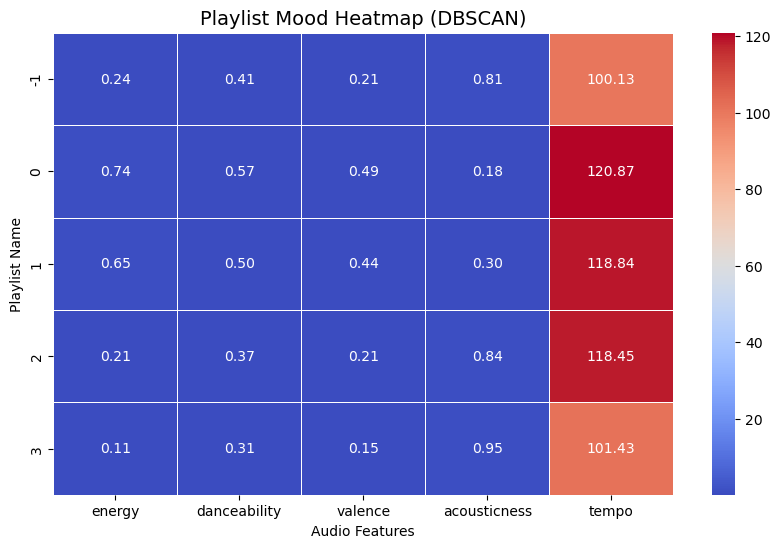

In [167]:
dbscan_profile = spotify_dbscan.groupby('dbscan_cluster')[[
    'energy', 'danceability', 'valence', 'acousticness', 'tempo'
]].mean()

display(dbscan_profile)

plt.figure(figsize=(10, 6))

sns.heatmap(
    dbscan_profile,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Playlist Mood Heatmap (DBSCAN)", fontsize=14)
plt.xlabel("Audio Features")
plt.ylabel("Playlist Name")
plt.show()


<Axes: xlabel='playlist_name'>

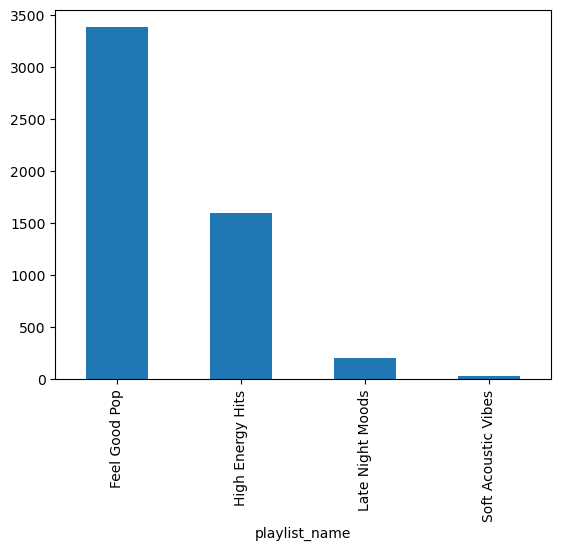

In [168]:
dbscan_playlist_names = {
    0: "High Energy Hits",
    1: "Feel Good Pop",
    2: "Soft Acoustic Vibes",
    3: "Late Night Moods"
}
spotify_dbscan['playlist_name'] = (
    spotify_dbscan['dbscan_cluster']
    .map(dbscan_playlist_names)
)
spotify_dbscan['playlist_name'].value_counts().plot(kind='bar')

In [169]:
spotify_dbscan.groupby('playlist_name')[[
    'name', 'artist','playlist_name'
]].sample(5, random_state=42)


,name,artist,playlist_name
571,Super Bass ...,Nicki Minaj,Feel Good Pop
461,The Waiting ...,Angel Olsen,Feel Good Pop
677,Middle ...,DJ Snake,Feel Good Pop
1211,Rebel Rebel - 2016 Remaster ...,David Bowie,Feel Good Pop
2206,Ignition - Remix ...,R. Kelly,Feel Good Pop
3572,Mourning ...,Nirvana 2002,High Energy Hits
4757,Zerrissen ...,Juli,High Energy Hits
3760,Hell Is Where the Heart Is ...,Edge Of Sanity,High Energy Hits
2950,Something Just Like This - Don Diablo Remix ...,The Chainsmokers,High Energy Hits
4382,In The Beginning ...,Amorphis,High Energy Hits


In [170]:
dbscan_image_map = {
    "High Energy Hits": "C:\\Users\\USER\\Applied-Statistical-Data-Analysis-class_exercises\\ASDA_2025_Group_1_Portfolio_new\\additional_material\\Plots\\Energy.png",
    "Feel Good Pop": "C:\\Users\\USER\\Applied-Statistical-Data-Analysis-class_exercises\\ASDA_2025_Group_1_Portfolio_new\\additional_material\\Plots\\Pop.png",
    "Soft Acoustic Vibes": "C:\\Users\\USER\\Applied-Statistical-Data-Analysis-class_exercises\\ASDA_2025_Group_1_Portfolio_new\\additional_material\\Plots\\Vibes.png",
    "Late Night Moods": "C:\\Users\\USER\\Applied-Statistical-Data-Analysis-class_exercises\\ASDA_2025_Group_1_Portfolio_new\\additional_material\\Plots\\Moods.png"
}

spotify_dbscan['playlist_image'] = (
    spotify_dbscan['playlist_name']
    .map(dbscan_image_map)
)


In [171]:
playlist_export = spotify_dbscan[[
    'name',
    'artist',
    'html',
    'dbscan_cluster',
    'playlist_name'
]]


In [172]:
playlist_export = playlist_export.sort_values(
    by=['playlist_name']
)
playlist_export.to_csv(
    'spotify_dbscan_playlists.csv',
    index=False
)

# Fill out report

In [173]:
# Load the final dataset
df = pd.read_csv("spotify_dbscan_playlists.csv")

# Columns to describe (these are the only ones in the dataset)
columns = ["name", "artist", "html", "dbscan_cluster", "playlist_name"]

summary = []

for col in columns:
    summary.append({
        "column": col,
        "data_type": df[col].dtype,
        "n_unique": df[col].nunique(),
        "example_values": ", ".join(df[col].dropna().astype(str).unique()[:3])
    })

summary_df = pd.DataFrame(summary)
summary_df


,column,data_type,n_unique,example_values
0,name,object,5011,"Ravel: Boléro, M. 81 ..."
1,artist,object,2176,Maurice Ravel ...
2,html,object,5171,https://open.spotify.com/track/7E1ErYYCn0lYjHO...
3,dbscan_cluster,int64,5,"1, 0, 3"
4,playlist_name,object,4,"Feel Good Pop, High Energy Hits, Late Night Moods"
